# Collecte et nettoyage des données 
## Évaluation sommative 3 : **Validation des données**

L’objectif de ce projet est de documenter un processus complet de validation des données appliqué au jeu de données
bank-full.csv. Ce dernier contient 45 211 observations provenant de campagnes de télémarketing menées par une banque
pour promouvoir un dépôt à terme.

## 1.Une description des données

### 1.1. chargement des bibliothèques et des données

In [1]:
# importation des bibliothèques 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro, f_oneway, pearsonr
from pandera import Column, DataFrameSchema, Check
import pandera as pa


In [2]:
# chargement et apperçu des données
chemin = 'bank-full.csv'
df = pd.read_csv(chemin, sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# Aperçu de la structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## 1.2. Provenance

Le dataset *bank-full.csv* provient du **UCI Machine Learning Repository** et regroupe 
les informations collectées lors de **campagnes de télémarketing menées par une banque portugaise**. 
L’objectif de ces campagnes était de promouvoir un dépôt à terme.

Les variables du dataset décrivent :
- les caractéristiques sociodémographiques des clients (age, job, marital, education),
- leur situation financière (balance),
- leur historique de contact (duration, campaign, previous, pdays),
- les informations de communication (contact, month, day),
- et le résultat final (y : a souscrit ou non).



## 1.3 Variables du dataset

| Variable      | Description |
|---------------|-------------|
| age           | Âge du client |
| job           | Métier / profession du client |
| marital       | État civil (single, married, divorced) |
| education     | Niveau d’éducation |
| default       | Le client a-t-il un crédit en défaut ? (yes/no) |
| balance       | Solde moyen annuel du compte bancaire (en euros) |
| housing       | Possède-t-il un prêt immobilier ? |
| loan          | Possède-t-il un prêt personnel ? |
| contact       | Type de contact utilisé (cellular, telephone) |
| day           | Jour du dernier contact |
| month         | Mois du dernier contact |
| duration      | Durée de l’appel (en secondes) |
| campaign      | Nombre de contacts durant cette campagne |
| pdays         | Nombre de jours depuis le dernier contact précédent (−1 = jamais contacté) |
| previous      | Nombre de contacts lors des campagnes précédentes |
| poutcome      | Résultat de la campagne précédente |
| y             | Le client a-t-il souscrit au dépôt à terme ? (yes/no) |


## 1.4 Dimensions du dataset

- **Nombre de lignes :** 45 211  
- **Nombre de colonnes :** 17  

Ce volume important permet d’effectuer une analyse statistique robuste et représentative.




## 2. Les etapes de validation de donnees

### 2.1. Statistiques descriptives des variables numériques

### 2.1.1 Mesures de tendance centrale

In [4]:
#Separation des variables numériques et catégorielles
numeric_cols = ["age", "balance", "duration", "campaign", "pdays", "previous"]
categorical_cols = [col for col in df.columns if col not in numeric_cols]

# Mesures de tendance centrale pour les variables numériques
tendance_centrale = pd.DataFrame({
    "mean": df[numeric_cols].mean(),
    "median": df[numeric_cols].median(),
    "mode": df[numeric_cols].mode().iloc[0]
})
tendance_centrale

,mean,median,mode
age,40.936210,39.0,32
balance,1362.272058,448.0,0
duration,258.163080,180.0,124
campaign,2.763841,2.0,1
pdays,40.197828,-1.0,-1
previous,0.580323,0.0,0


d'après le tableau descriptif nous remarquons que :
- Âge: Les clients ont en moyenne 41 ans, avec une médiane de 39 ans. L’âge varie entre 18 et 95 ans, témoignant d’une population plutôt diversifiée.
- Balance (solde annuel moyen): La moitié des clients ont un solde inférieur ou égal à 448 €. Les valeurs vont de –8019 € à 102 127 €, indiquant une forte dispersion et la présence probable de valeurs aberrantes.
- Jour du dernier contact (day): Le dernier contact a généralement lieu vers le 16e jour du mois, avec une répartition homogène allant du 1er au 31. Variable descriptive sans tendance particulière.
- Durée du dernier contact (duration): La durée des appels varie de 0 à 4918 secondes. La moyenne (258 s) est supérieure à la médiane (180 s), révélant une asymétrie à droite due à quelques appels particulièrement longs.
- Nombre de contacts durant la campagne (campaign): Le nombre de contacts varie de 1 à 63. La plupart des clients (75 %) ont été contactés trois fois ou moins, mais quelques valeurs extrêmes indiquent des campagnes très insistantes.
- pdays (jours depuis le dernier contact d’une campagne précédente): La valeur -1 domine largement, indiquant que la majorité des clients n’avaient jamais été recontactés auparavant. Les valeurs positives jusqu’à 871 jours concernent une minorité de clients précédemment approchés.
- previous (nombre de contacts avant cette campagne): La majorité des clients n’avaient jamais été contactés dans les campagnes antérieures (médiane = 0). Quelques valeurs élevées montrent que certains clients ont déjà été sollicités de nombreuses fois.

### 2.1.2. Mesures de Dispersion (étendue, variance, écart-type, IQR)

In [5]:
# Mesures de dispersion
dispersion = df[numeric_cols].agg(["min", "max", "mean","var", "std"]).transpose() 
dispersion["Etendu"] = dispersion["max"] - dispersion["min"]

# Calcul de l'IQR pour chaque variable numérique
q1 = df[numeric_cols].quantile(0.25)
q3 = df[numeric_cols].quantile(0.75)
iqr = q3 - q1

dispersion["Q1"] = q1
dispersion["Q3"] = q3
dispersion["IQR"] = iqr

dispersion

,min,max,mean,var,std,Etendu,Q1,Q3,IQR
age,18.0,95.0,40.936210,1.127581e+02,10.618762,77.0,33.0,48.0,15.0
balance,-8019.0,102127.0,1362.272058,9.270599e+06,3044.765829,110146.0,72.0,1428.0,1356.0
duration,0.0,4918.0,258.163080,6.632057e+04,257.527812,4918.0,103.0,319.0,216.0
campaign,1.0,63.0,2.763841,9.597733e+00,3.098021,62.0,1.0,3.0,2.0
pdays,-1.0,871.0,40.197828,1.002577e+04,100.128746,872.0,-1.0,-1.0,0.0
previous,0.0,275.0,0.580323,5.305841e+00,2.303441,275.0,0.0,0.0,0.0


Interprétation des mesures de dispersion par variable
-  Âge : dispersion modérée, distribution assez concentrée autour de la quarantaine.
- Solde annuel moyen (balance): variable très dispersée, très asymétrique, fortement impactée par des outliers.
- Jour du dernier contact (day): pas de tendance particulière, dispersion normale.
- Durée du dernier contact (duration): distribution très asymétrique (longue queue à droite), valeurs extrêmes importantes.
- Nombre de contacts durant la campagne (campaign): dispersion globalement faible mais présence de valeurs extrêmes rares.
- pdays (jours depuis un contact précédent) : variable fortement déséquilibrée, –1 domine largement (code = jamais contacté).
- previous (contacts avant la campagne actuelle): variable extrêmement déséquilibrée, quasi tous les clients sont nouveaux dans les campagnes.

### 2.1.3 Mesures de relations entre les variables

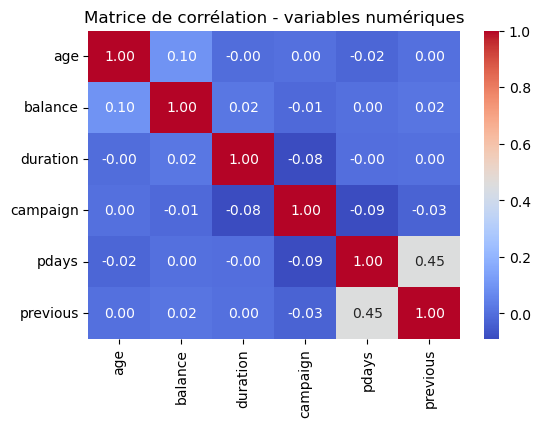

In [6]:
# Matrice de corrélation pour les variables numériques
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation - variables numériques")
plt.show()

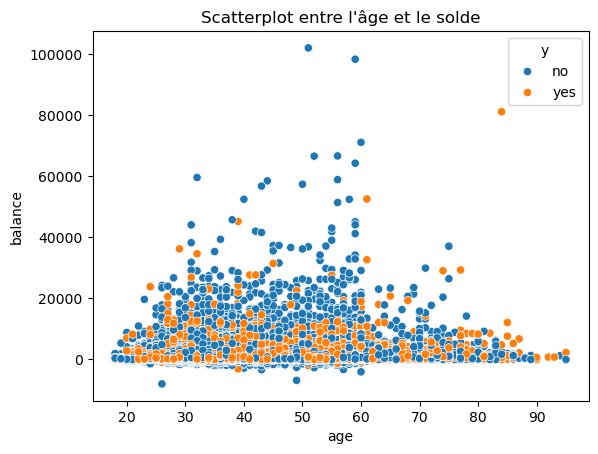

In [7]:
# visualisation scatterplot entre 'age' et 'balance'
sns.scatterplot(x='age', y='balance', data=df, hue='y')
plt.title("Scatterplot entre l'âge et le solde")
plt.show()

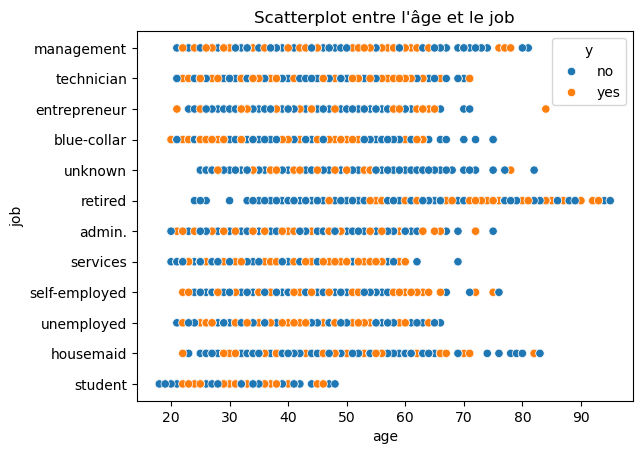

In [20]:
# visualisation scatterplot entre 'age' et 'job'
sns.scatterplot(x='age', y='job', data=df, hue='y')
plt.title("Scatterplot entre l'âge et le job")
plt.show()

L’analyse de la matrice de corrélation montre que les variables numériques du dataset sont faiblement corrélées entre elles,
avec des coefficients proches de zéro dans la majorité des cas. Cela indique une quasi-indépendance entre les variables et limite les risques 
de multicolinéarité. La seule corrélation notable est celle entre pdays et previous (0,45), ce qui s’explique par le fait que ces deux variables 
reflètent l’historique des contacts marketing. Les autres relations étant très faibles, chaque variable apporte une information distincte, 
ce qui est favorable pour la modélisation.

### 2.1.4 Visualisation des distributions des variables numeriques

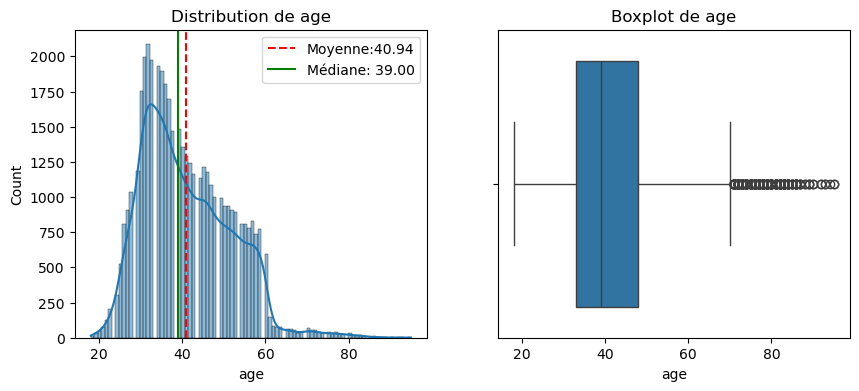

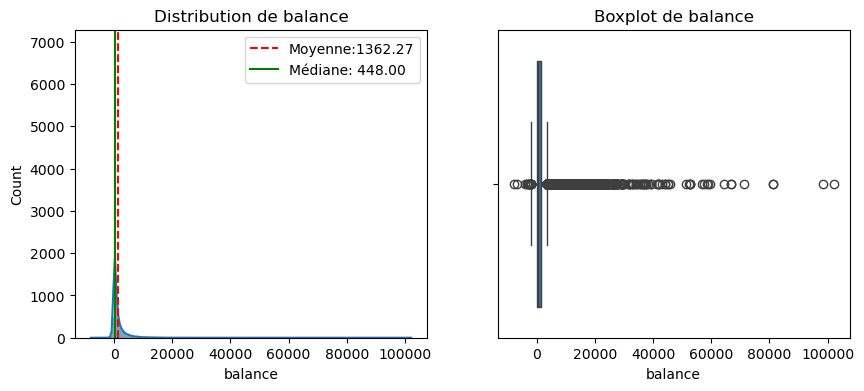

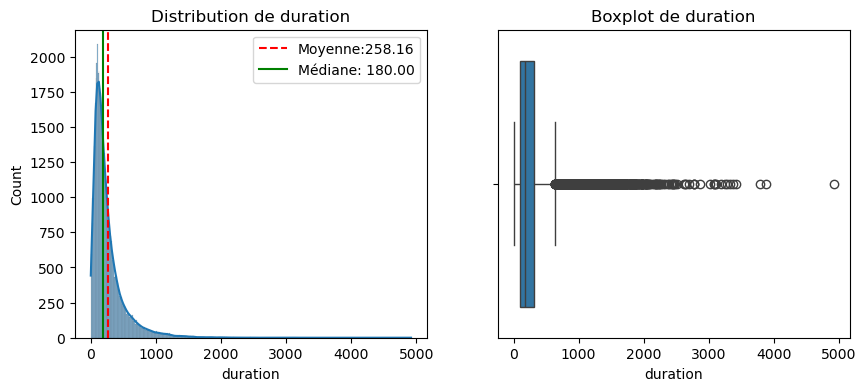

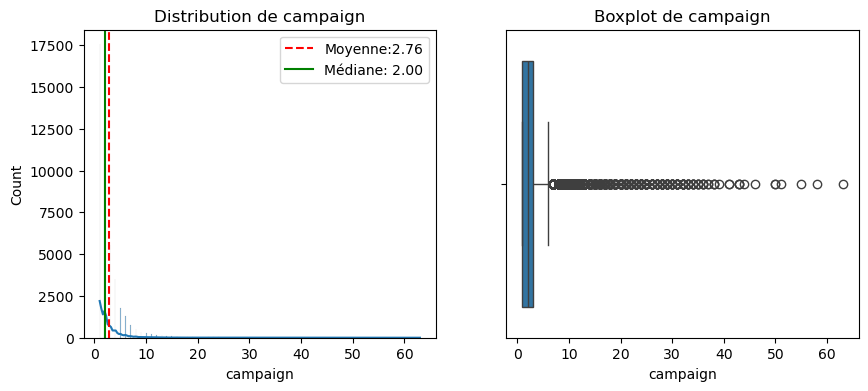

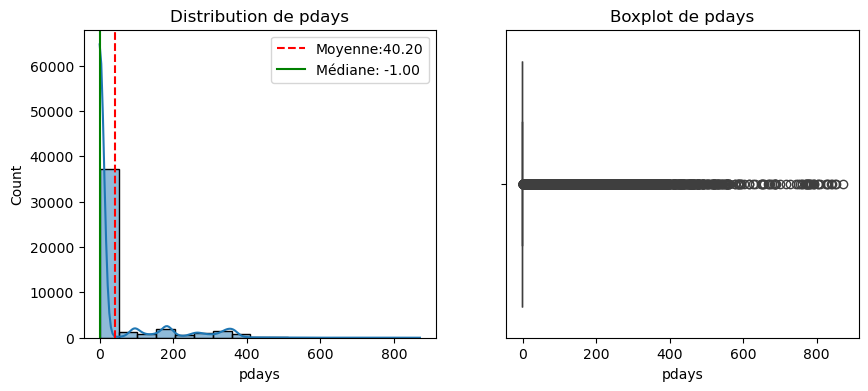

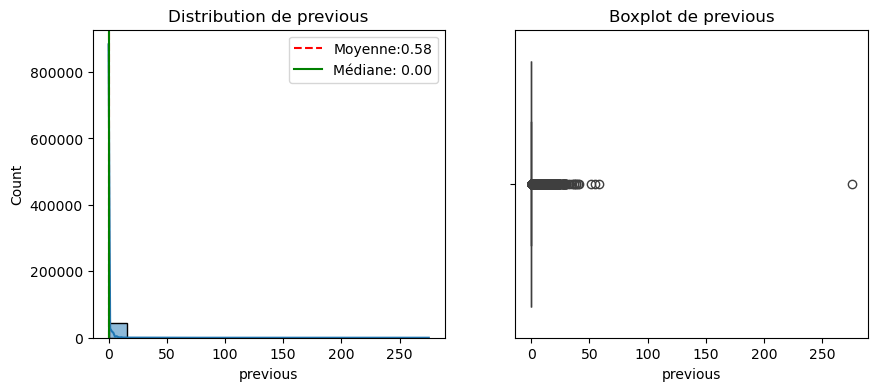

In [8]:
for col in numeric_cols:
    plt.figure(figsize=(10,4))
    Moyenne = df[col].mean()
    Médiane = df[col].median()
    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True)
    plt.axvline(df[col].mean(), color='red', linestyle='--', label=f'Moyenne:{Moyenne:.2f}')
    plt.axvline(df[col].median(), color='green', linestyle='-', label=f'Médiane: {Médiane:.2f}')
    plt.legend()
    plt.title(f"Distribution de {col}")
 
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
 
    plt.savefig(f"{col}_distribution.png", dpi=300)
   
    plt.show()

Les distributions numériques du dataset montrent des tendances claires avec :
- Variables relativement équilibrées et proches d'une distribution normale :Âge
- Variables très asymétriques avec outliers : Balance; Durée du dernier contact; Nombre de contacts durant la campagne; pdays; previous
- Variables uniformes : day (jour du dernier contact)

En conclusion :
- Le dataset contient plusieurs variables avec longues queues à droite, nécessitant prudence lors de la modélisation (normalisation, transformation log, etc.).
- Les variables pdays et previous montrent que la majorité des clients n’ont aucun historique marketing, ce qui influence fortement l'interprétation.
- La variable duration est très informative mais très déséquilibrée.

## Analyse des variables categorielle

In [9]:
#Statistique descriptive pour les variables catégorielles avec describe()
df[categorical_cols].describe(include='object').transpose(  )



,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959
y,45211,2,no,39922


C:\Users\USER\AppData\Local\Temp\ipykernel_23888\1641458627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')


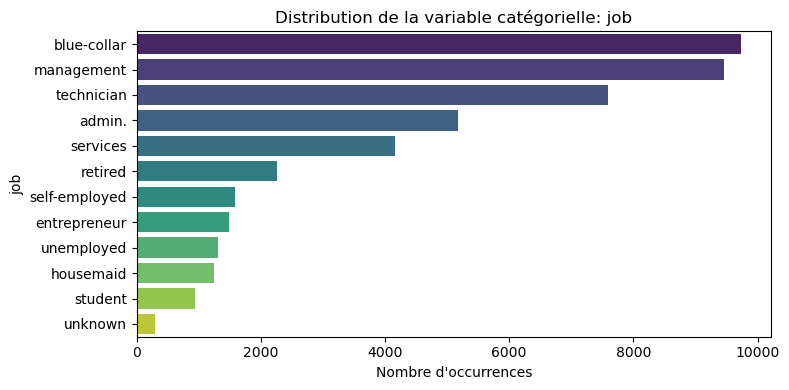

C:\Users\USER\AppData\Local\Temp\ipykernel_23888\1641458627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')


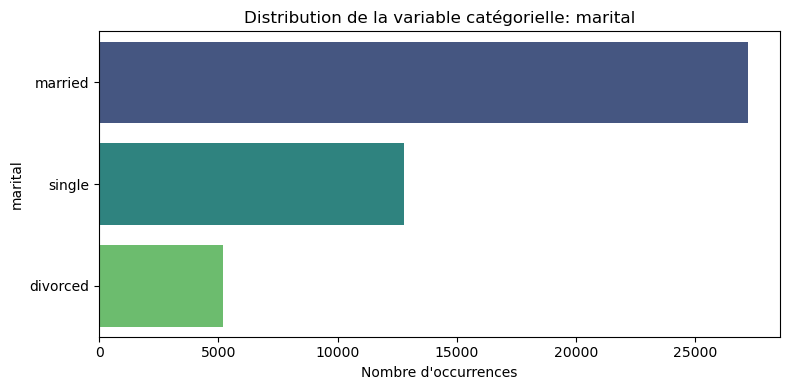

C:\Users\USER\AppData\Local\Temp\ipykernel_23888\1641458627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')


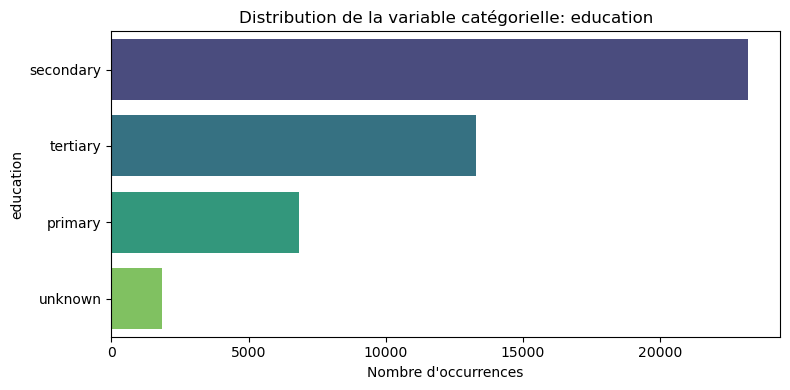

C:\Users\USER\AppData\Local\Temp\ipykernel_23888\1641458627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')


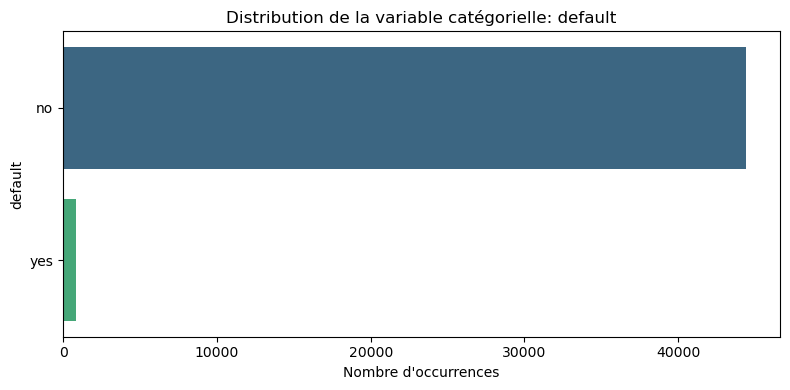

C:\Users\USER\AppData\Local\Temp\ipykernel_23888\1641458627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')


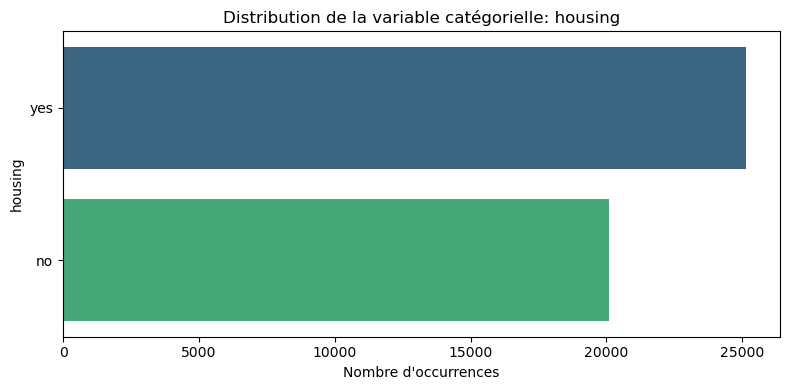

C:\Users\USER\AppData\Local\Temp\ipykernel_23888\1641458627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')


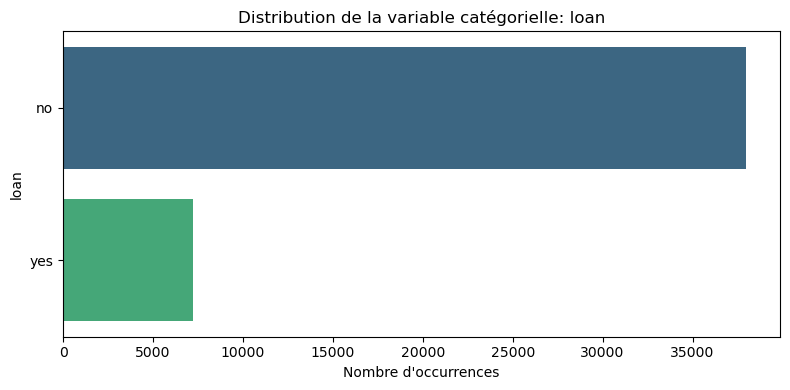

C:\Users\USER\AppData\Local\Temp\ipykernel_23888\1641458627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')


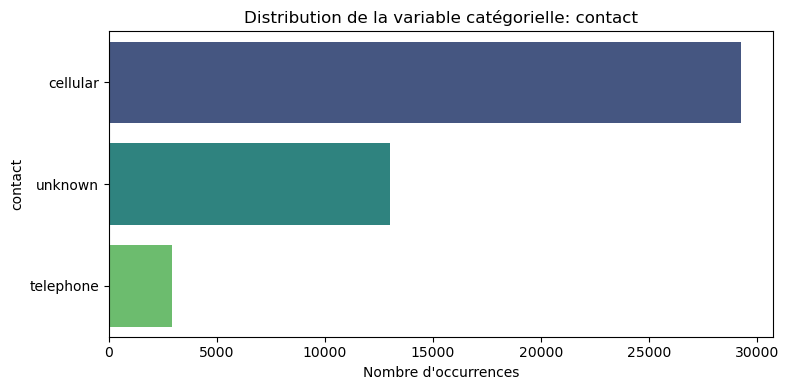

C:\Users\USER\AppData\Local\Temp\ipykernel_23888\1641458627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')


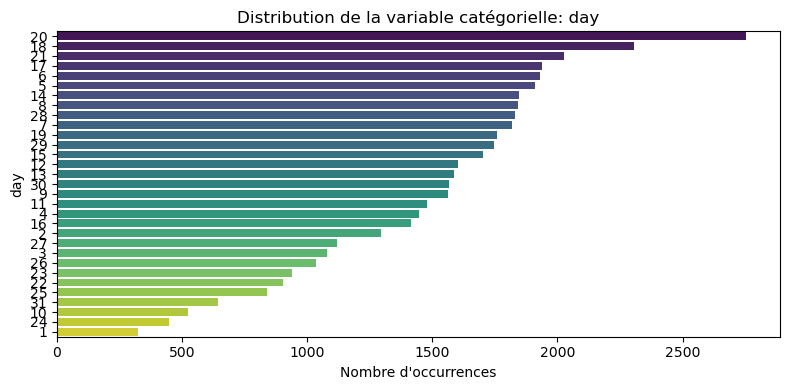

C:\Users\USER\AppData\Local\Temp\ipykernel_23888\1641458627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')


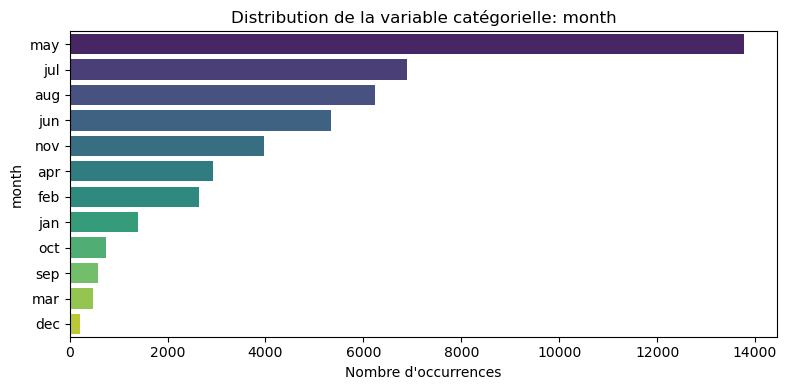

C:\Users\USER\AppData\Local\Temp\ipykernel_23888\1641458627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')


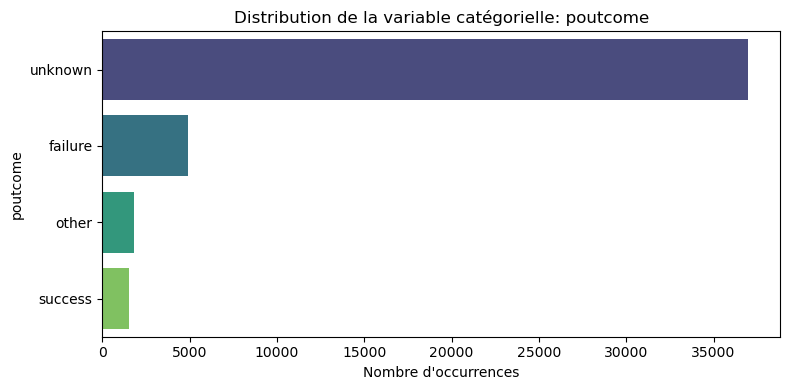

C:\Users\USER\AppData\Local\Temp\ipykernel_23888\1641458627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')


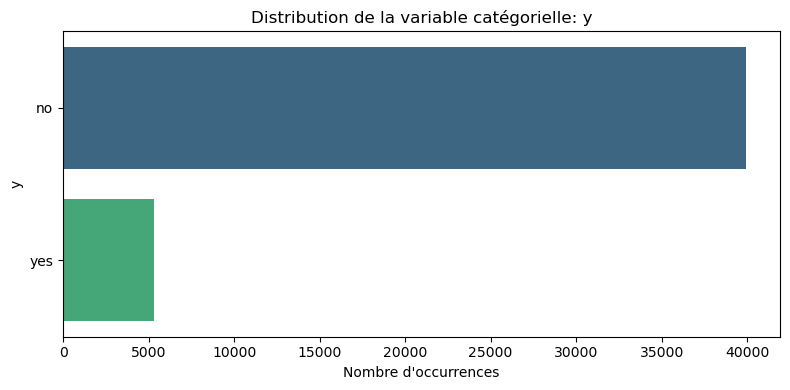

In [10]:
#visualisation des variables catégorielles
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')
    plt.title(f"Distribution de la variable catégorielle: {col}")
    plt.xlabel("Nombre d'occurrences")
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(f"{col}_categorical_distribution.png", dpi=300)
    plt.show()
    

#Commentaires sur les distributions observées
- Variables catégorielles : Des variables comme 'job' et 'education' montrent une répartition inégale des catégories, avec certaines professions ou niveaux d'éducation étant beaucoup plus fréquents que d'autres. Cela peut refléter la démographie de la clientèle de la banque.
- Implications : la répartition inégale des catégories dans les variables catégorielles peut nécessiter des techniques de rééchantillonnage ou de pondération lors de la modélisation.


## 2.2 Détection des anomalies

Cette section présente les anomalies identifiées dans le jeu de données bank-full.csv, ainsi que les décisions associées quant à leur traitement.
Les anomalies sont classées selon quatre catégories :

1. valeurs manquantes
2. Doublons
3. problèmes de format ou de type
4. incohérences logiques
5. valeurs aberrantes (outliers)

### 2.2.1 Vérification des valeurs manquantes

In [11]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Le dataset ne contient aucune valeur manquante, ce qui simplifie la validation.

### 2.2.2. Vérification des doublons

In [12]:
df.duplicated().sum()

0

### 2.2.3.Types de données & formats

In [13]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

### 2.2.4 Détection des incohérences logiques 

**Règle 1 : pdays = -1 ⇒ previous = 0**

In [14]:
df[(df['pdays'] == -1) & (df['previous'] > 0)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


Interpretation: La vérification de la cohérence entre les variables pdays et previous ne révèle aucune anomalie : aucun client n’a pdays = -1 
tout en ayant previous > 0.
Cela confirme que la règle métier « pdays = -1 ⇒ previous = 0 » est respectée dans l’ensemble du jeu de données.

**Règle 2 : Le nombre de contacts campaign doit être ≥ 1**

In [15]:
df[df['campaign'] < 1]


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


La variable campaign représente :

« le nombre de contacts effectués durant cette campagne pour ce client »

Donc la valeur 0 serait illogique :
Si un client est dans le dataset, c’est qu’il a été contacté au moins une fois.

**Règle 3 : L’âge doit être réaliste (18 à 100 ans)**

In [16]:
df[(df['age'] < 18) | (df['age'] > 100)]


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


L’âge des clients doit respecter des bornes réalistes. Dans un contexte bancaire, il est logique de s’attendre à ce que l’âge soit compris entre 18 et 100 ans.
La vérification ci dessus a été effectuée 
Aucun enregistrement ne présente un âge inférieur à 18 ans ni supérieur à 100 ans.
Cela indique que la variable age est cohérente et valide dans l’ensemble du dataset.
Aucune correction n’est nécessaire.

**Règle 4:Les mois (month) doivent appartenir à la liste officielle**

In [17]:
mois_valides = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
df[~df["month"].isin(mois_valides)]


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


Les quatre règles métier définies sont totalement respectées par le dataset.
Aucune incohérence logique n’a été détectée.
Les données sont donc considérées comme fiables et prêtes pour l’analyse ou la modélisation.

## 2.3. Validation contextuelle (règles métier)

### 2.3.1 Règles métier : définition du schéma Pandera

In [18]:
# Définition d'un schéma Pandera pour formaliser quelques règles métier de base
"""Schéma de validation des données avec Pandera
Ce schéma inclut des règles métier pour valider les colonnes du jeu de données bank-full.csv.
"""

job_categories = [
    "admin.", "unknown", "unemployed", "management", "housemaid",
    "entrepreneur", "student", "blue-collar", "self-employed",
    "retired", "technician", "services"
]

marital_categories = ["married", "divorced", "single"]
education_categories = ["unknown", "secondary", "primary", "tertiary"]
binary_yes_no = ["yes", "no"]

schema = DataFrameSchema(
    {
        "age": Column(
            int,
            checks=[
                Check.ge(18),
                Check.le(100)
            ],
            nullable=False,
            description="Âge du client (entre 18 et 100 ans)"
        ),
        "balance": Column(
            int,
            checks=[
                Check.ge(-10000)  # selon contexte, on peut ajuster cette valeur minimale
            ],
            description="Solde annuel moyen du compte bancaire"
        ),
        "duration": Column(
            int,
            checks=[
                Check.ge(0),
                Check.le(5000)
            ],
            description="Durée du dernier appel (en secondes)"
        ),
        "campaign": Column(
            int,
            checks=[Check.ge(1)],
            description="Nombre de contacts lors de la campagne actuelle"
        ),
        "job": Column(
            str,
            checks=[Check.isin(job_categories)],
            description="Type d'emploi"
        ),
        "marital": Column(
            str,
            checks=[Check.isin(marital_categories)],
            description="Statut marital"
        ),
        "education": Column(
            str,
            checks=[Check.isin(education_categories)],
            description="Niveau d'étude"
        ),
        "default": Column(
            str,
            checks=[Check.isin(binary_yes_no)],
            description="Crédit en défaut"
        ),
        "housing": Column(
            str,
            checks=[Check.isin(binary_yes_no)],
            description="Prêt immobilier"
        ),
        "loan": Column(
            str,
            checks=[Check.isin(binary_yes_no)],
            description="Prêt personnel"
        ),
        "y": Column(
            str,
            checks=[Check.isin(binary_yes_no)],
            description="Souscription au dépôt à terme (cible)"
        ),
    },
    coerce=True,
    description="Schéma métier de validation pour bank-full.csv"
)


c:\Users\USER\anaconda3\envs\collecte_nettoyage_donnees\lib\site-packages\pandera\_pandas_deprecated.py:149: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


### 2.3.2 Application des règles métier

In [19]:
# Validation du DataFrame avec le schéma défini
try:
    df_validated = schema.validate(df, lazy=True)
    print("Validation Pandera réussie : toutes les règles métier sont satisfaites.")
except pa.errors.SchemaErrors as err:
    print("Des violations de règles métier ont été détectées.\n")
    # Résumé des erreurs
    print(err.failure_cases.head())

Validation Pandera réussie : toutes les règles métier sont satisfaites.


### Commentaire Validation contextuelle (pandera)
Les règles métier formalisées dans le schéma Pandera permettent de vérifier la cohérence des âges, des valeurs numériques et des modalités des variables catégorielles en fonction de la logique de la banque.​
Les éventuelles violations identifiées dans err.failure_cases doivent être analysées et traitées, puis documentées pour garantir la transparence et la traçabilité du processus de validation. Dans notre cas, aucune violation n'a été détecté selon les règles metiers etablies

## Conclusion générale

Le processus complet de validation a permis :
- de comprendre la structure statistique du dataset,
- d’identifier les principales anomalies (unknown, outliers, codes métier),
- de vérifier la cohérence logique des variables (pdays/previous),
- et de valider les données selon quatre règles métier avec Pandera.

Les données peuvent désormais être utilisées dans un processus d’analyse ou 
de modélisation avec un niveau de confiance élevé.